# Load Modules

In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [299]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import (
    boxplot_histogram,
    clean_up_categoricals
    )
from pa_lib.file import (
    project_dir,
    load_bin,
    load_csv,
    load_xlsx
    )
from pa_lib.util import (
    cap_words
    
    )                     

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 300


In [23]:
from pa_lib.data import desc_col

In [138]:
## Lazy Recursive Job Dependency Request:
from pa_lib.job import request_job

################################################################################
## Recursive Dependency Check:
request_job(job_name="bd_prepare.py",  current= "Today") # output: bd_data.feather

15:34:07 [INFO] [ipykernel_launcher.py] requests 'bd_prepare.py'
15:34:07 [INFO] [ipykernel_launcher.py]: Not running job 'bd_prepare.py': result is current ('Today') from 2019-11-05 15:27:15.887908.


# Load Datasets

In [260]:
with project_dir("vkprog\\predictions"):
    #pred_rebuild_df = load_bin("20190701_pred_rebuild.feather")
    pred_rebuild_df = load_bin("20190701_pred_rebuild_without_sales_filter.feather")
    
    pred_rscript_df_raw = load_xlsx("20190701_EK_LIST_2W_KOMPLETT.xlsx")
    
    row_select = (pred_rscript_df_raw
                  .loc[:,"ENDKUNDE_NR"]
                  .map(lambda x: str(x).isdigit())
                 )
    
    pred_rscript_df = (
        pred_rscript_df_raw
        .loc[row_select,:]
        .astype({"ENDKUNDE_NR": "int64"})
        .rename(columns={"ENDKUNDE_NR": "Endkunde_NR"})
        )
    
    del pred_rscript_df_raw

with project_dir("vkprog"):
    bd_raw = load_bin("bd_data.feather").rename(
        mapper=lambda name: cap_words(name, sep="_"), axis="columns"
    )
    bd = bd_raw.loc[(bd_raw.Netto > 0)].pipe(clean_up_categoricals)
    del bd_raw
    

14:13:00 [INFO] Started loading binary file
14:13:00 [INFO] Reading from file C:\Users\stc\data\vkprog\predictions\20190701_pred_rebuild_without_sales_filter.feather
14:13:00 [INFO] Finished loading binary file in 0.0s (0.02s CPU)
14:13:00 [INFO] Started loading xlsx file
14:13:00 [INFO] Reading from file C:\Users\stc\data\vkprog\predictions\20190701_EK_LIST_2W_KOMPLETT.xlsx
14:13:02 [INFO] Finished loading xlsx file in 2.68s (2.67s CPU)
14:13:02 [INFO] Started loading binary file
14:13:02 [INFO] Reading from file C:\Users\stc\data\vkprog\bd_data.feather
14:13:03 [INFO] Finished loading binary file in 0.16s (1.34s CPU)


In [261]:
#desc_col(pred_rscript_df)

In [262]:
bd.head(10)

,Endkunde_NR,Endkunde,EK_Abc,EK_Boni,EK_Plz,EK_Ort,EK_Land,EK_HB_Apg_Kurzz,EK_Kam_Betreut,EK_Aktiv,Agentur,AG_Hauptbetreuer,Verkaufsberater,Endkunde_Branchengruppe_ID,Endkunde_Branchengruppe,Endkunde_Nbranchengruppe_ID,Endkunde_Nbranchengruppe,Endkunde_Branchenkat_ID,Endkunde_Branchenkat,Endkunde_Nbranchenkat_ID,Endkunde_Nbranchenkat,Auftrag_Branchengruppe_ID,Auftrag_Branchengruppe,Auftrag_Nbranchengruppe_ID,Auftrag_Nbranchengruppe,Auftrag_Branchenkat_ID,Auftrag_Branchenkat,Auftrag_Nbranchenkat_ID,Auftrag_Nbranchenkat,Agps_NR,Segment,KV_NR,KV_Typ,Kampagnen_Status,Kampagne_Erfassungsdatum,Kampagne_Beginn,Auftragsart,Res_Dat,Annullation_Datum,Aush_Von,Dauer,Vertrag,Brutto,Netto,Agglo,PF,Kamp_Beginn_Jahr,Kamp_Beginn_KW,Kamp_Beginn_KW_2,Kamp_Beginn_KW_4,Kamp_Erfass_Jahr,Kamp_Erfass_KW,Kamp_Erfass_KW_2,Kamp_Erfass_KW_4
2,123010,Perrodin Voyages,NaN,gut,1920,Martigny,SCHWEIZ,NaN,0,1,NaN,NaN,VRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,405,WG - Reisen / Hotels / Sanatorien,NaN,NaN,10,WB - Freizeit / Touristik,NaN,NaN,1035675,Traffic,540946,KDVTLG,4,2008-10-01,2009-01-01,Traffic Auftrag,2008-10-01,NaT,2009-01-01,365,Ja,1067,1067,NaN,Hecktafel,2009,1,1,1,2008,40,39,37
3,411700,"Maharaja, traiteur, cuisine indienne",E,gut,1004,Lausanne,SCHWEIZ,SAO,0,1,NaN,NaN,YTA,405,WG - Reisen / Hotels / Sanatorien,NaN,NaN,10,WB - Freizeit / Touristik,NaN,NaN,405,WG - Reisen / Hotels / Sanatorien,NaN,NaN,10,WB - Freizeit / Touristik,NaN,NaN,1035902,Traffic,541110,KDVTLG,4,2008-10-01,2009-01-01,Traffic Auftrag,2008-10-01,NaT,2009-01-01,365,Ja,1125,1125,NaN,"Schiebekarton,Seitenbanner,Teilheck Fenster",2009,1,1,1,2008,40,39,37
4,482093,McDonald's Suisse Restaurants Sàrl,A,gut,1023,Crissier,SCHWEIZ,BEG,1,1,OMD Schweiz AG,FER,NIE,405,WG - Reisen / Hotels / Sanatorien,NaN,NaN,10,WB - Freizeit / Touristik,NaN,NaN,405,WG - Reisen / Hotels / Sanatorien,NaN,NaN,10,WB - Freizeit / Touristik,NaN,NaN,1035961,APG|SGA,541161,KDVTLG,4,2008-10-01,2008-12-29,langfristiger Vertrag,2008-10-01,NaT,2008-12-29,371,Ja,5500,5500,"90768,91372,93379,A0230,A0261,A0351,A0371,A058...","Dachlängsformat,Diverse,F12,F12L,F12LR,F200,F2...",2009,1,1,1,2008,40,39,37
15,503170,Fondazione agli Sassu e Helenita Oliveres,E,gut,6900,Lugano,SCHWEIZ,SOL,0,1,NaN,NaN,ROS,720,WG - Dienstleistung,NaN,NaN,15,WB - Dienstleistung,NaN,NaN,990,WG - Veranstaltungen,NaN,NaN,22,WB - Veranstaltungen,NaN,NaN,1041421,APG|SGA,542512,KPG,4,2008-10-13,2009-02-02,Kommerziell,2008-10-13,NaT,2009-02-02,14,Nein,3675,3675,"A5002,A5113,A5192,A5250",F12,2009,6,5,5,2008,42,41,41
16,122839,Opéra de Lausanne,B,gut,1002,Lausanne,SCHWEIZ,MZB,0,1,NaN,NaN,BTU,990,WG - Veranstaltungen,NaN,NaN,22,WB - Veranstaltungen,NaN,NaN,990,WG - Veranstaltungen,NaN,NaN,22,WB - Veranstaltungen,NaN,NaN,1044117,APG|SGA,543250,KPG,4,2008-10-16,2009-01-26,Kommerziell,2008-10-16,NaT,2009-01-26,14,Nein,297,297,"95401,95822,A0351,A2125,A2196,A5586,A5890,A593...","F12,F12L,F200,F200L,F4C,F4M,F4S,TrafficMediaSc...",2009,5,5,5,2008,42,41,41
17,122839,Opéra de Lausanne,B,gut,1002,Lausanne,SCHWEIZ,MZB,0,1,NaN,NaN,BTU,990,WG - Veranstaltungen,NaN,NaN,22,WB - Veranstaltungen,NaN,NaN,990,WG - Veranstaltungen,NaN,NaN,22,WB - Veranstaltungen,NaN,NaN,1058702,APG|SGA,543250,KPG,4,2008-10-16,2009-01-26,Kommerziell,2008-11-19,NaT,2009-01-26,14,Nein,860,860,"95401,95822,A0351,A2125,A2196,A5586,A5890,A593...","F12,F12L,F200,F200L,F4C,F4M,F4S,TrafficMediaSc...",2009,5,5,5,2008,42,41,41
19,124088,St. Galler Kantonalbank AG,B,gut,9001,St. Gallen,SCHWEIZ,REM,0,1,NaN,NaN,ERS,470,WG - Finanzwirtschaft,NaN,NaN,12,WB - Finanzwirtschaft / Versicherung,NaN,NaN,470,WG - Finanzwirtschaft,NaN,NaN,12,WB - Finanzwirtschaft / Versicherung,NaN,NaN,1055263,APG|SGA,543877,KPG,4,2008-10-21,2009-04-06,Kommerziell,2008-11-11,NaT,2009-04-06,14,Nein,5145,4631,"93293,93339,93379,93402,A0261,A3203,A3251,A327...","F12,F200,F200L,F4C,F4M,Hängekarton,Hängekarton...",2009,15,15,13,2008,43,43,41
22,438673,Carrefour Groupe Provencia / Margencel,D,gut,74200,Anthy-sur-Léman,FRANCE,DME,0,1,Swiss Media Pr

## DWH Data (actual reservations)

In [263]:
def customer_netto(KW_2, year):
    row_select = (
        # No cancellations/ Annulationen:
        (bd.loc[:,"Kampagnen_Status"] != 3)    &
        
        # Which two week period:
        (bd.loc[:,"Kamp_Erfass_KW_2"] == KW_2) &
        
        # Which year:
        (bd.loc[:,"Kamp_Erfass_Jahr"] == year) &
        
        # Only profitable campaigns:
        (bd.loc[:,"Netto"] >0)
        )

    reality_df = (bd
        .loc[row_select,:]
        .groupby(["Endkunde_NR","Kamp_Erfass_Jahr","Kamp_Erfass_KW_2"])
        .agg({"Netto": np.nansum})
        .reset_index(inplace=False)
        )
    print(f"(year = {year}, KW_2 = {KW_2}), {reality_df.shape}")
    return reality_df

In [264]:
reality_2019_df = customer_netto(KW_2=27,year=2019)
reality_2018_df = customer_netto(KW_2=27,year=2018)

(year = 2019, KW_2 = 27), (621, 4)
(year = 2018, KW_2 = 27), (395, 4)


In [265]:
netto_sum_2018 = reality_2018_df.loc[:,"Netto"].sum()
print("Numbers from 2018, KW_2 == 45 :\n")
print(f"#Campaigns (Reservations):\n {reality_2018_df.shape[0]}")
print(f"Netto-Sum of Reservations:\n {netto_sum_2018}")


Numbers from 2018, KW_2 == 45 :

#Campaigns (Reservations):
 395
Netto-Sum of Reservations:
 8890023


In [288]:
comparision_df = (
    reality_2019_df
        #
        .merge(
            pred_rscript_df
            .eval("Prob_KW27 = prob_KW27*0.01")
            .loc[:,["Endkunde_NR","Prob_KW27"]],
            on="Endkunde_NR",
            how="right"
        )
        .merge(
            pred_rebuild_df
            .loc[:,["Endkunde_NR","Prob_1"]],
            on="Endkunde_NR",
            how="inner"
        )
        .fillna(
            value={
                "Kamp_Erfass_Jahr": (reality_2019_df
                                     .loc[:,"Kamp_Erfass_Jahr"]
                                     .max()),
                "Kamp_Erfass_KW_2": (reality_2019_df
                                     .loc[:,"Kamp_Erfass_KW_2"]
                                     .min()),
                "Netto": 0,
                "Prob_KW27": 0,
            
            }
        )
    )
comparision_df.sample(20)

,Endkunde_NR,Kamp_Erfass_Jahr,Kamp_Erfass_KW_2,Netto,Prob_KW27,Prob_1
3254,134772,2019,27,0.0,0.027,0.259119
618,465142,2019,27,0.0,0.109,0.634558
9419,559528,2019,27,0.0,0.008,0.068305
9262,602488,2019,27,0.0,0.009,0.398764
8813,629398,2019,27,0.0,0.010,0.094700
714,606647,2019,27,0.0,0.089,0.528521
33,113031,2019,27,1251.0,0.030,0.488812
5796,483711,2019,27,0.0,0.018,0.487124
1650,641042,2019,27,0.0,0.039,0.406381
10245,613674,2019,27,0.0,0.006,0.042937


In [289]:
comparision_df.sort_values("Prob_KW27", ascending=True).head(50)

,Endkunde_NR,Kamp_Erfass_Jahr,Kamp_Erfass_KW_2,Netto,Prob_KW27,Prob_1
11679,595843,2019,27,0.0,0.0,0.264279
11646,651944,2019,27,0.0,0.0,0.144369
11645,571532,2019,27,0.0,0.0,0.204516
11644,649826,2019,27,0.0,0.0,0.205719
11643,615229,2019,27,0.0,0.0,0.064889
11642,377771,2019,27,0.0,0.0,0.485762
11641,505201,2019,27,0.0,0.0,0.365032
11640,567083,2019,27,0.0,0.0,0.395797
11639,100314,2019,27,0.0,0.0,0.233074
11638,621447,2019,27,0.0,0.0,0.296848


In [290]:
display(desc_col(comparision_df))
display(comparision_df.describe())

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/11680,11680
Kamp_Erfass_Jahr,category,0/11680,1
Kamp_Erfass_KW_2,category,0/11680,1
Netto,float64,0/11680,312
Prob_KW27,float64,0/11680,312
Prob_1,float64,0/11680,11640


,Endkunde_NR,Netto,Prob_KW27,Prob_1
count,11680.000000,11680.000000,11680.000000,11680.000000
mean,491469.217038,550.049658,0.027923,0.226662
std,190970.289027,8630.070814,0.057577,0.138697
min,100034.000000,0.000000,0.000000,0.019811
25%,474372.250000,0.000000,0.010000,0.111531
50%,582884.500000,0.000000,0.017000,0.198559
75%,625387.500000,0.000000,0.027000,0.324880
max,656801.000000,532605.000000,0.998000,0.824726


In [277]:
comparision_df = (
    comparision_df
        .eval("Netto_rscript = Prob_KW27 * Netto")
        .eval("Netto_rebuild = Prob_1    * Netto")
    )

In [278]:
comparision_df.head(10)

,Endkunde_NR,Kamp_Erfass_Jahr,Kamp_Erfass_KW_2,Netto,Prob_KW27,Prob_1,Netto_rscript,Netto_rebuild
0,100641,2019,27,10570.0,0.011,0.325371,116.270,3439.171041
1,100648,2019,27,42467.0,0.226,0.443560,9597.542,18836.649770
2,101648,2019,27,1359.0,0.027,0.418901,36.693,569.286624
3,101703,2019,27,7174.0,0.997,0.657147,7152.478,4714.369062
4,101767,2019,27,11328.0,0.261,0.498594,2956.608,5648.067539
5,102268,2019,27,956.0,0.181,0.336899,173.036,322.075726
6,102687,2019,27,24599.0,0.112,0.535878,2755.088,13182.068906
7,103005,2019,27,3371.0,0.196,0.515746,660.716,1738.580391
8,103102,2019,27,19585.0,0.329,0.493347,6443.465,9662.196421
9,103868,2019,27,8672.0,0.516,0.468910,4474.752,4066.386024


In [279]:
comparision_df.describe()

,Endkunde_NR,Netto,Prob_KW27,Prob_1,Netto_rscript,Netto_rebuild
count,11680.000000,11680.000000,11670.000000,11680.000000,11670.000000,11680.000000
mean,491469.217038,550.049658,0.027947,0.226662,107.306814,235.583690
std,190970.289027,8630.070814,0.057596,0.138697,3018.052590,3847.252453
min,100034.000000,0.000000,0.000000,0.019811,0.000000,0.000000
25%,474372.250000,0.000000,0.010000,0.111531,0.000000,0.000000
50%,582884.500000,0.000000,0.017000,0.198559,0.000000,0.000000
75%,625387.500000,0.000000,0.027000,0.324880,0.000000,0.000000
max,656801.000000,532605.000000,0.998000,0.824726,239601.728000,182085.446752


In [280]:
comparision_df.agg({"Netto_rscript": sum, "Netto_rebuild": sum})

Netto_rscript    1.252271e+06
Netto_rebuild    2.751617e+06
dtype: float64

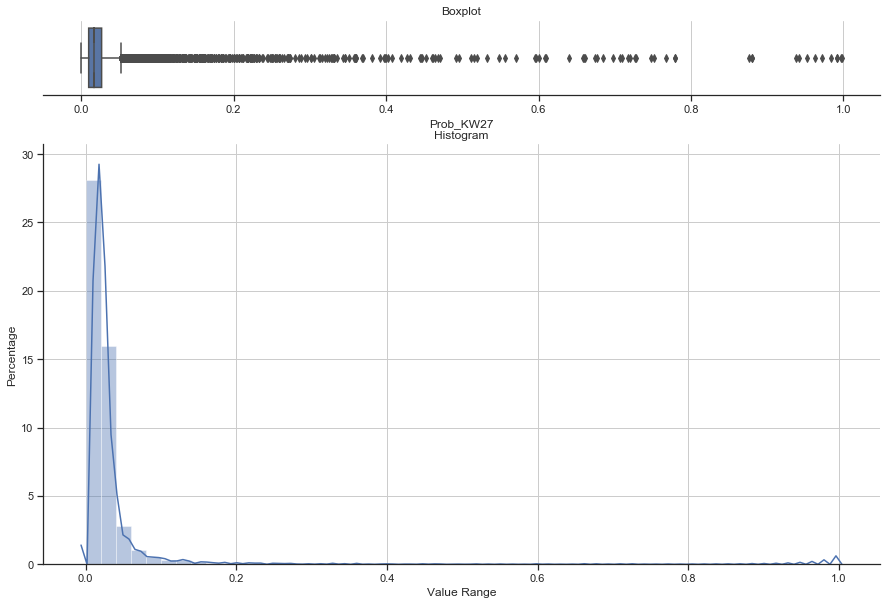

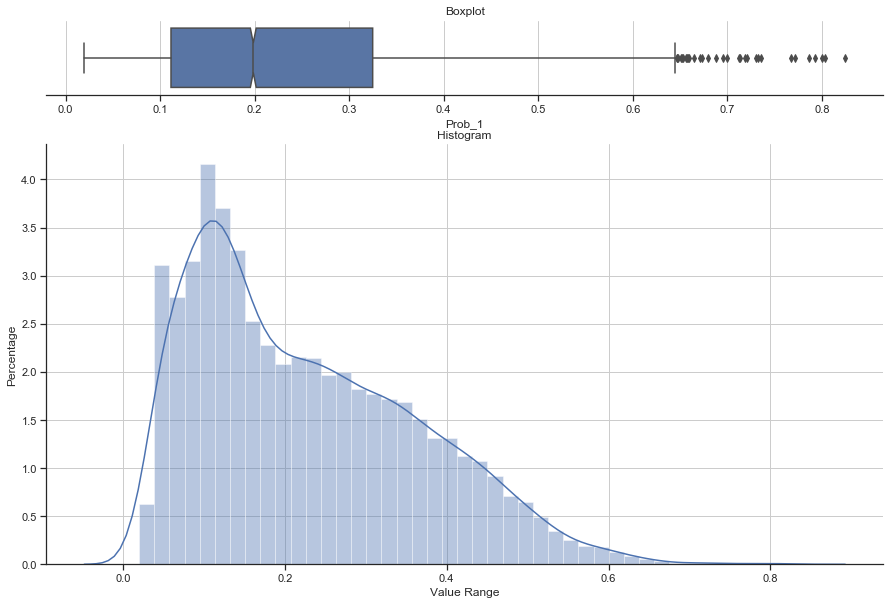

In [291]:
boxplot_histogram(comparision_df.loc[:,"Prob_KW27"])
boxplot_histogram(comparision_df.loc[:,"Prob_1"])

In [313]:
cutoffs = pd.Series(np.arange(0,1,0.001))

In [316]:
def success_sum(cutoff,model):
    row_select = comparision_df.loc[:,model] >= cutoff
    return comparision_df.loc[row_select,"Netto"].sum()
    

In [319]:
rebuild_series = cutoffs.map(lambda x: success_sum(x,model="Prob_1"))
rscript_series = cutoffs.map(lambda x: success_sum(x,model="Prob_KW27"))

In [322]:
import matplotlib
import matplotlib.pyplot as plt

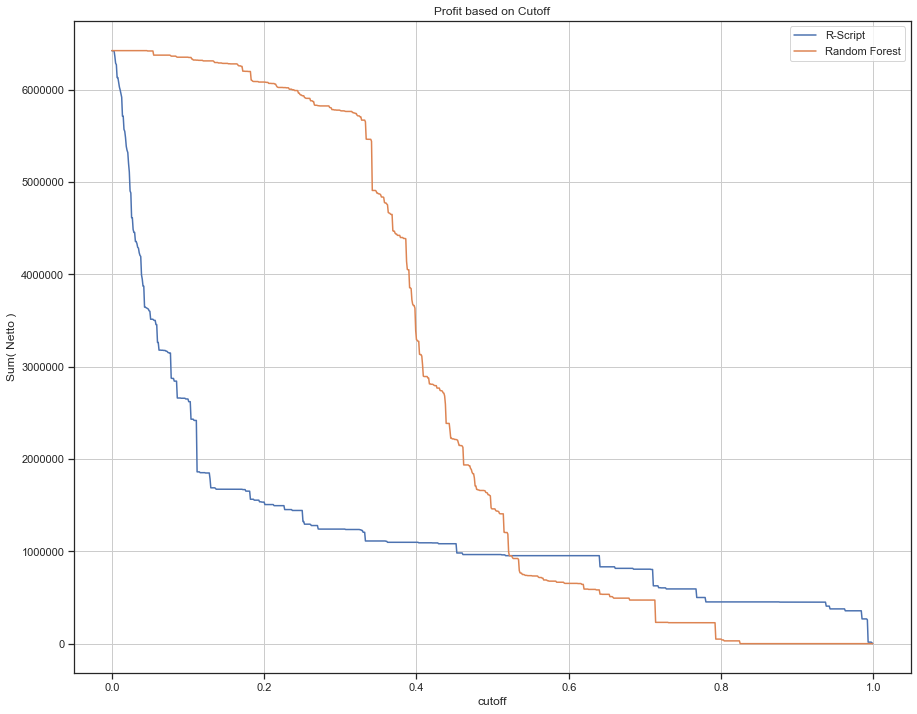

In [347]:
fig, ax = plt.subplots(figsize=(15,12))


ax.plot(cutoffs, rscript_series,label="R-Script")
ax.plot(cutoffs, rebuild_series,label="Random Forest")

ax.set(xlabel='cutoff', ylabel='Sum( Netto )',
       title='Profit based on Cutoff')
ax.grid()

#fig.savefig("test.png")
plt.legend(loc=0)
plt.show()